In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import triangle
import matplotlib.pyplot as plt
from lm import LM
import scipy as sp
jnp.set_printoptions(precision=4,linewidth=120)


In [42]:
N=100
Nx=20
rng=np.random.default_rng(seed=123)
arr = np.tile(np.arange(N).reshape(N,1),(1,Nx))
offset = rng.permuted(np.tile(np.arange(1,N),(N,1)), axis=1)[:,:Nx-1]
arr[:,1:]+=offset
arr %= N
x = jnp.asarray(rng.uniform(size=N))
a = rng.uniform(size=(N,Nx))
b = jnp.sum(a*x[arr]**2,axis=1)
x0 = x+rng.uniform(-0.01,0.01,size=N)

In [43]:
@jax.jit
def f(x):
    return jnp.sum(a*x[arr]**2,axis=1)-b

In [44]:
res=LM(f,x0, L=1e7, maxiter=1000, ftol=1e-12)

In [73]:
Nside=16
Nsquare=Nside*4
v=np.linspace(0,1,Nside,endpoint=False)
z=np.zeros(Nside)
o=np.ones(Nside)
square=np.c_[np.r_[v,o,1-v,z],np.r_[z,v,o,1-v]]
square_seg = np.c_[np.arange(square.shape[0]-1),np.arange(1,square.shape[0])]
square_seg = np.r_[square_seg,np.array([[square.shape[0]-1,0]])]

Ncircle = 24
r=0.2
theta = np.linspace(0, 2 * np.pi, Ncircle, endpoint=False)
circle = np.stack([r*np.cos(theta)+0.5, r*np.sin(theta)+0.5], axis=1)
circle_seg = np.c_[np.arange(circle.shape[0]-1), np.arange(1,circle.shape[0])]
circle_seg = np.r_[circle_seg,np.array([[circle.shape[0]-1,0]])]
circle_seg+=square.shape[0]

In [74]:
A = dict(vertices=np.r_[square,circle], segments=np.r_[square_seg,circle_seg], holes=[[0.5, 0.5]])
B = triangle.triangulate(A, 'qpa0.003D')

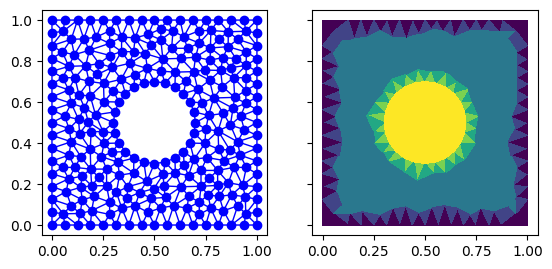

In [75]:
tr=B['triangles']
verts = B['vertices']
interior = np.where(np.ravel(B['vertex_markers'])==0)[0]
Nv = verts.shape[0]
f=np.zeros(Nv)
f[:Nsquare]=1.
f[Nsquare:Nsquare + Ncircle]=2.
f[Nsquare+Ncircle:]=1.5
f=jnp.asarray(f)
fig1, ax = plt.subplots(1,2, sharex=True, sharey=True)
ax[0].set_aspect('equal')
_=ax[0].triplot(verts[:,0],verts[:,1],'bo-',triangles=tr,lw=1)
ax[1].set_aspect('equal')
_=ax[1].tripcolor(verts[:,0],verts[:,1],f)

In [76]:
def get_neighbors(i):
    return np.setdiff1d(np.unique(np.ravel(tr[np.where(tr==i)[0]])),i)

def get_five_neighbors(i):
    nb=get_neighbors(i)
    if nb.size<5:
        for ii in nb:
            nb=np.union1d(nb, get_neighbors(ii))
        nb=np.setdiff1d(nb,i)
    d=np.sum((verts[i]-verts[nb])**2,axis=1)
    if nb.size>5:
        return nb[np.argpartition(d,5)[:5]]
    else:
        return nb

In [77]:
# f = a1*x^2 + a2*y^2 + a3*x + a4*y + a5*xy + f0
# df/dx = 2a1*x + a3 + a5*y
# df/dy = 2a2*y + a4 + a5*x
# df2/dx2 = 2a1
# df2/dy2 = 2a2
#df2/dxdy = a5

def get_LU(i):
    n5 = get_five_neighbors(i)
    x,y = (verts[n5]-verts[i]).T
    return jax.scipy.linalg.lu_factor(np.c_[x**2, y**2, x, y, x*y]),n5

def get_LUs(interior):
    LUs=[]
    pivs=[]
    n5s=[]
    for i in interior:
        (LU, piv), n5 = get_LU(i)
        LUs.append(LU)
        pivs.append(piv)
        n5s.append(n5)
    n5s=jnp.stack(n5s)
    LUs=jnp.stack(LUs)
    pivs=jnp.stack(pivs)
    return LUs, pivs, n5s

LUs, pivs, n5s=get_LUs(interior)
lu_solve_vec=jax.vmap(jax.scipy.linalg.lu_solve,in_axes=((0,0),0))
@jax.jit
def get_coeffs(f):
    return lu_solve_vec((LUs, pivs), jnp.take(f,n5s)-f[interior,None])

In [78]:
@jax.jit
def eqs(f_interior, f=f):
    f=f.at[interior].set(f_interior)
    a=get_coeffs(f)
    return 2*jnp.sum(a[:,:2],axis=1)
    

In [79]:
res=LM(eqs, f[interior], L=1000, rho_tol = 0.1, maxiter=100, xtol=1e-6, ftol=1e-6)
sol = f.at[interior].set(res.x)

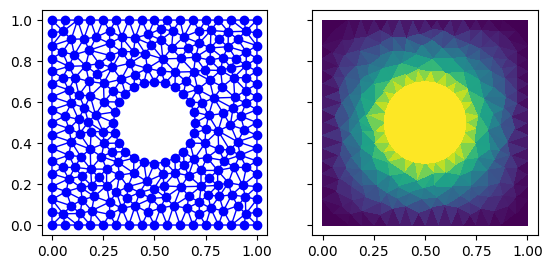

In [80]:
fig2, ax = plt.subplots(1,2, sharex=True, sharey=True)
ax[0].set_aspect('equal')
_=ax[0].triplot(verts[:,0],verts[:,1],'bo-',triangles=tr,lw=1)
ax[1].set_aspect('equal')
_=ax[1].tripcolor(verts[:,0],verts[:,1],sol)